## Capstone Project
### Machine Learning Engineer Nanodegree

After extensive research, I decided to run a Kaggle competition on Mercari Price Suggestion Challenge as my capstone project .(https://www.kaggle.com/c/mercari-price-suggestion-challenge)

Mercari (Latin word means “to trade.”, http://www.mercari.com) is a Japanese unicorn startup – call it an advanced version of Craigslist. It was founded in 2013 by Hiroshi Toshima, Ryo Ishizuka, Shintaro Yamada, and Tommy Tomishima. It is a community-sourced customer-to-customer mobile marketplace to securely buy and sell anything and everything.  Mercari extended to the US and the UK in 2014. 

In this competition, Mercari is challenging me to build an algorithm that automatically suggests the right product prices for its customers.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
import string
import re
import gc

from scipy.sparse import csr_matrix,hstack

In [3]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import LabelEncoder

In [4]:
from sklearn.ensemble import RandomForestRegressor

In [6]:
import lightgbm as lgb

### I. Data Exploration

#### Load the train file and read basic data information

In [7]:
train=pd.read_table('https://storage.googleapis.com/merca/train.tsv')

In [8]:
train.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [9]:
train.describe().round(2)

,train_id,item_condition_id,price,shipping
count,1482535.00,1482535.00,1482535.00,1482535.00
mean,741267.00,1.91,26.74,0.45
std,427971.14,0.90,38.59,0.50
min,0.00,1.00,0.00,0.00
25%,370633.50,1.00,10.00,0.00
50%,741267.00,2.00,17.00,0.00
75%,1111900.50,3.00,29.00,1.00
max,1482534.00,5.00,2009.00,1.00


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [11]:
train.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description'],
      dtype='object')

#### Load the test file and read basic data information

In [12]:
test=pd.read_table('https://storage.googleapis.com/merca/test.tsv')

In [13]:
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693359 entries, 0 to 693358
Data columns (total 7 columns):
test_id              693359 non-null int64
name                 693359 non-null object
item_condition_id    693359 non-null int64
category_name        690301 non-null object
brand_name           397834 non-null object
shipping             693359 non-null int64
item_description     693359 non-null object
dtypes: int64(3), object(4)
memory usage: 37.0+ MB


In [15]:
test.describe().round(3)

,test_id,item_condition_id,shipping
count,693359.000,693359.000,693359.000
mean,346679.000,1.906,0.448
std,200155.647,0.903,0.497
min,0.000,1.000,0.000
25%,173339.500,1.000,0.000
50%,346679.000,2.000,0.000
75%,520018.500,3.000,1.000
max,693358.000,5.000,1.000


In [16]:
test.columns

Index(['test_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'shipping', 'item_description'],
      dtype='object')

#### data exploratory visualization

##### Target Variable: Price

In [17]:
train.price.describe().round(2)

count    1482535.00
mean          26.74
std           38.59
min            0.00
25%           10.00
50%           17.00
75%           29.00
max         2009.00
Name: price, dtype: float64

###### Price distribution

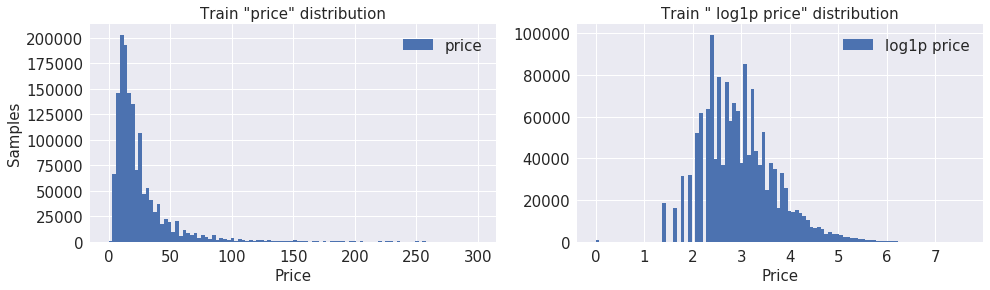

In [18]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.hist(train.price, bins=100,range=[0,300], label='price')
plt.title('Train "price" distribution', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('Samples', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)

plt.subplot(122)
plt.hist(np.log1p(train['price']), bins=100, label='log1p price')
plt.title('Train " log1p price" distribution', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()



###### Price Impacted by Category and Shipping Status

In [19]:
train['category_name']=train['category_name'].fillna('missing/missing/missing').astype(str)
train['gen_cat']=train['category_name'].apply(lambda x:x.split('/')[0])
train['sub_cat1']=train['category_name'].apply(lambda x:x.split('/')[1])
train['sub_cat2']=train['category_name'].apply(lambda x:x.split('/')[2])
train.drop('category_name',axis=1,inplace=True)
train.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,gen_cat,sub_cat1,sub_cat2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


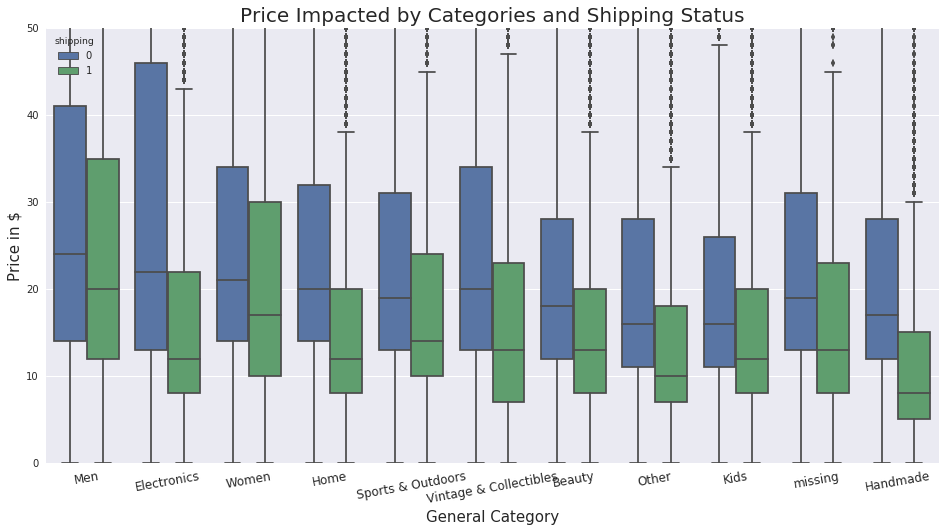

In [20]:
sns.set(rc={'figure.figsize':(16,8)})
ax=sns.boxplot(x='gen_cat',y='price',data=train,hue='shipping')
ax.set_xlabel('General Category',fontsize=15)
ax.set_ylabel('Price in $',fontsize=15)
ax.set_title('Price Impacted by Categories and Shipping Status',fontsize=20)
plt.xticks(rotation=10,fontsize=12)
ax.set_ylim([0, 50])
plt.show()

###### Number of rows price equals zeros

Total rows of 0-price: 874


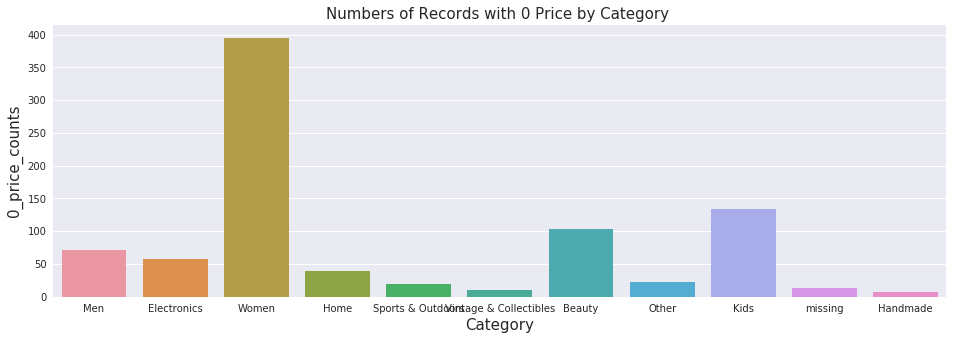

In [21]:
sns.set(rc={'figure.figsize':(16,5)})
print('Total rows of 0-price:',sum(train['price']==0))

lst=[]
cols=['category','0_price_counts']
for cat in train['gen_cat'].unique():
    lst.append([cat,sum((train['gen_cat']==cat)&(train['price']==0))])

zero_by_category=pd.DataFrame(lst,columns=cols)

ax=sns.barplot(x='category',y='0_price_counts',data=zero_by_category)
ax.set_title('Numbers of Records with 0 Price by Category ',fontsize=15)
ax.set_xlabel('Category',fontsize=15)
ax.set_ylabel('0_price_counts',fontsize=15)
plt.show()

###### Number of rows price larger then $1000

Total rows of over-1000-price: 167


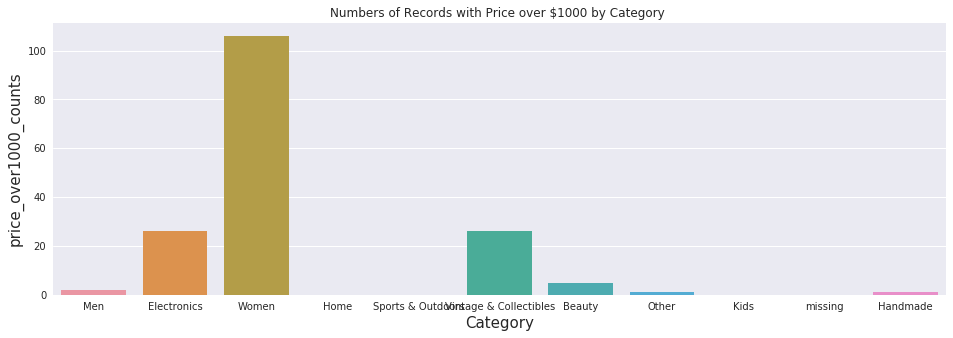

In [22]:
sns.set(rc={'figure.figsize':(16,5)})
print('Total rows of over-1000-price:',sum(train['price']>1000))

lst=[]
cols=['category','1000_price_counts']
for cat in train['gen_cat'].unique():
    lst.append([cat,sum((train['gen_cat']==cat)&(train['price']>1000))])

over1000_by_category=pd.DataFrame(lst,columns=cols)  

ax=sns.barplot(x='category',y='1000_price_counts',data=over1000_by_category)
ax.set_title('Numbers of Records with Price over $1000 by Category ')
ax.set_xlabel('Category',fontsize=15)
ax.set_ylabel('price_over1000_counts',fontsize=15)
plt.show()

###### price impacted by condition

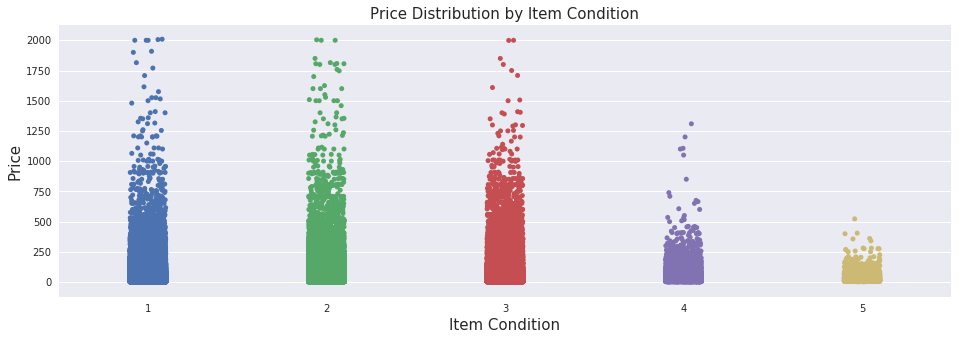

In [23]:
sns.set(rc={'figure.figsize':(16,5)})
ax=sns.stripplot(x='item_condition_id',y='price',data=train,jitter=True)
ax.set_title('Price Distribution by Item Condition',fontsize=15)
ax.set_xlabel('Item Condition',fontsize=15)
ax.set_ylabel('Price',fontsize=15)
plt.show()

##### Input Feature: shipping

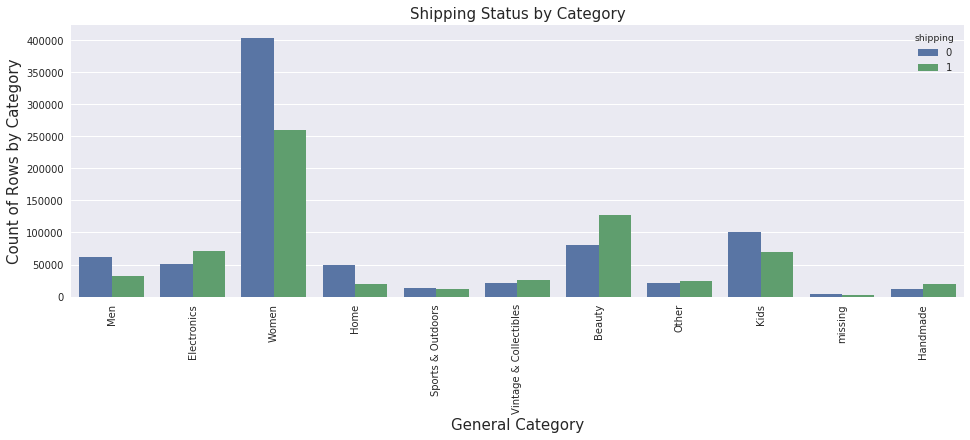

In [24]:
sns.set(rc={'figure.figsize':(16,5)})
ax=sns.countplot(x=train['gen_cat'],data=train,hue='shipping')
ax.set_title('Shipping Status by Category',fontsize=15)
ax.set_xlabel('General Category',fontsize=15)
ax.set_ylabel('Count of Rows by Category',fontsize=15)
plt.xticks(rotation=90)
plt.show()

##### Input Feature: item_condition_id

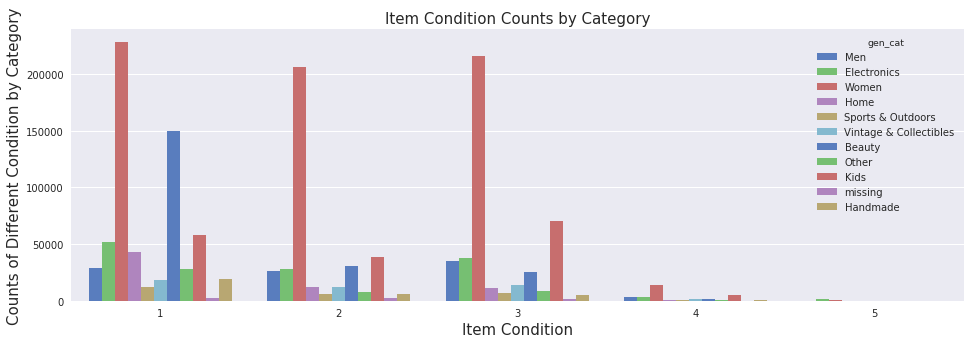

In [25]:
sns.set(rc={'figure.figsize':(16,5)})
ax=sns.countplot(x=train['item_condition_id'],data=train,hue='gen_cat',palette='muted')
ax.set_title('Item Condition Counts by Category',fontsize=15)
ax.set_xlabel('Item Condition',fontsize=15)
ax.set_ylabel('Counts of Different Condition by Category',fontsize=15)
plt.show()

###### Input Feature: category

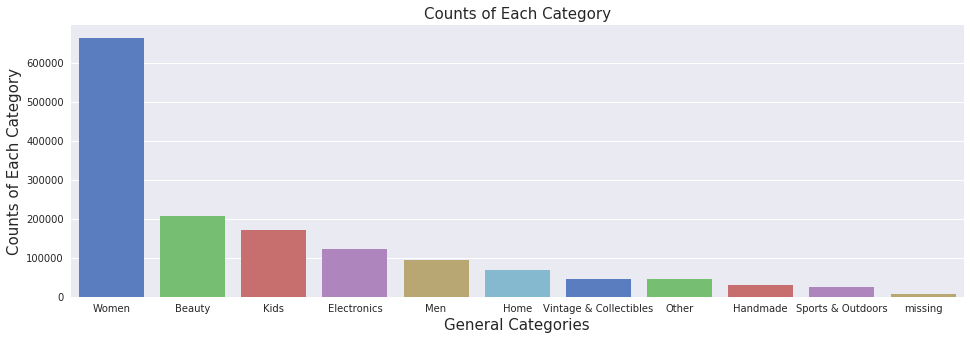

In [26]:
sns.set(rc={'figure.figsize':(16,5)})
ax=sns.countplot(x=train['gen_cat'],data=train,palette='muted',order=train['gen_cat'].value_counts().index)
ax.set_xlabel('General Categories',fontsize=15)
ax.set_ylabel('Counts of Each Category',fontsize=15)
ax.set_title('Counts of Each Category',fontsize=15)
plt.show()

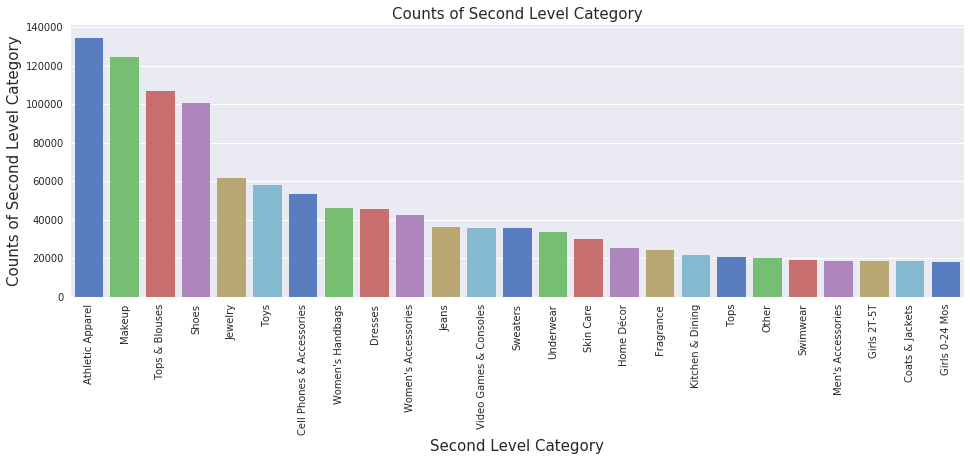

In [27]:
sns.set(rc={'figure.figsize':(16,5)})
ax=sns.countplot('sub_cat1',data=train,palette='muted',order=train['sub_cat1'].value_counts()[:25].index)
plt.xticks(rotation=90)
ax.set_xlabel('Second Level Category',fontsize=15)
ax.set_ylabel('Counts of Second Level Category',fontsize=15)
ax.set_title('Counts of Second Level Category',fontsize=15)
plt.show()

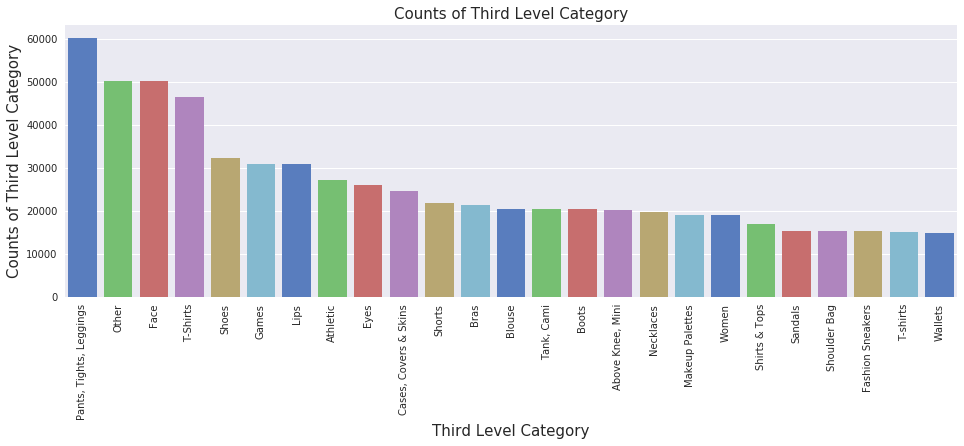

In [28]:
sns.set(rc={'figure.figsize':(16,5)})
ax=sns.countplot('sub_cat2',data=train,palette='muted',order=train['sub_cat2'].value_counts()[:25].index)
plt.xticks(rotation=90)
ax.set_xlabel('Third Level Category',fontsize=15)
ax.set_ylabel('Counts of Third Level Category',fontsize=15)
ax.set_title('Counts of Third Level Category',fontsize=15)
plt.show()

###### Input Feature:brand_name

In [29]:
train['brand_name'].fillna('missing',inplace=True)
print('Total brands:',len(train['brand_name'].unique()))

Total brands: 4810


In [30]:
print('Top 50 brands counts:\n')
top_50_brands=train[train['brand_name']!='missing']['brand_name'].value_counts()[:50]
print(top_50_brands)

Top 50 brands counts:

PINK                   54088
Nike                   54043
Victoria's Secret      48036
LuLaRoe                31024
Apple                  17322
FOREVER 21             15186
Nintendo               15007
Lululemon              14558
Michael Kors           13928
American Eagle         13254
Rae Dunn               12305
Sephora                12172
Coach                  10463
Disney                 10360
Bath & Body Works      10354
Adidas                 10202
Funko                   9237
Under Armour            8461
Sony                    7994
Old Navy                7567
Hollister               6948
Carter's                6385
Urban Decay             6210
The North Face          6172
Independent             5902
Too Faced               5794
Xbox                    5709
Brandy Melville         5680
Kate Spade              5411
MAC                     5302
Kendra Scott            5097
Gap                     5088
Tarte                   4984
UGG Australia       

In [31]:
print('Number of Brands appeared more than once:')
sum(train.groupby('brand_name')['brand_name'].count()>1)-1
# the value 'missing' doesnot count

Number of Brands appeared more than once:


3566

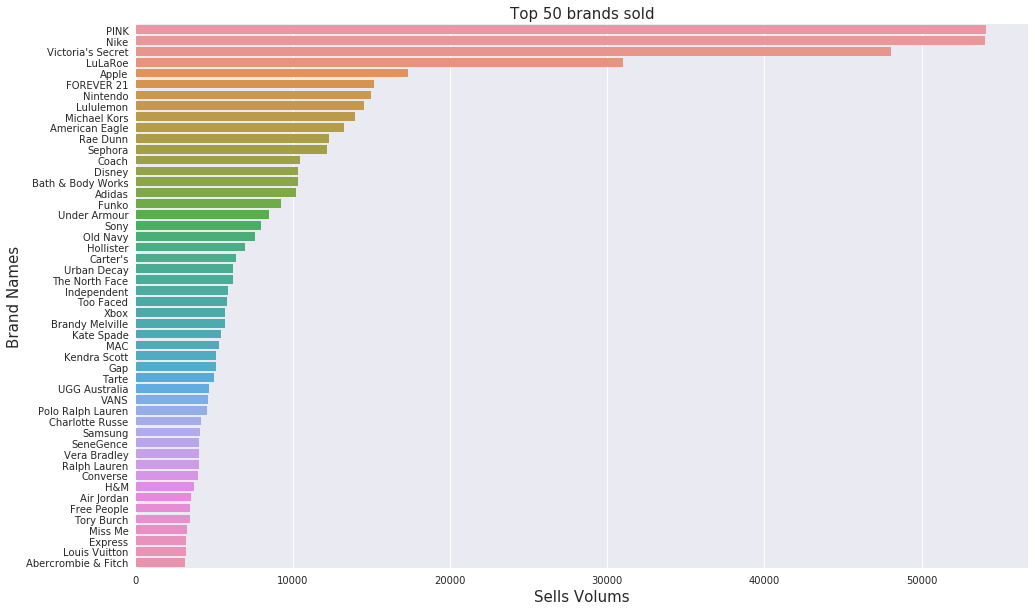

In [32]:
sns.set(rc={'figure.figsize':(16,10)})
ax=sns.barplot(y='index',x='brand_name',data=top_50_brands.reset_index())
ax.set_title('Top 50 brands sold',fontsize=15)
ax.set_xlabel('Sells Volums',fontsize=15)
ax.set_ylabel('Brand Names',fontsize=15)
plt.show()

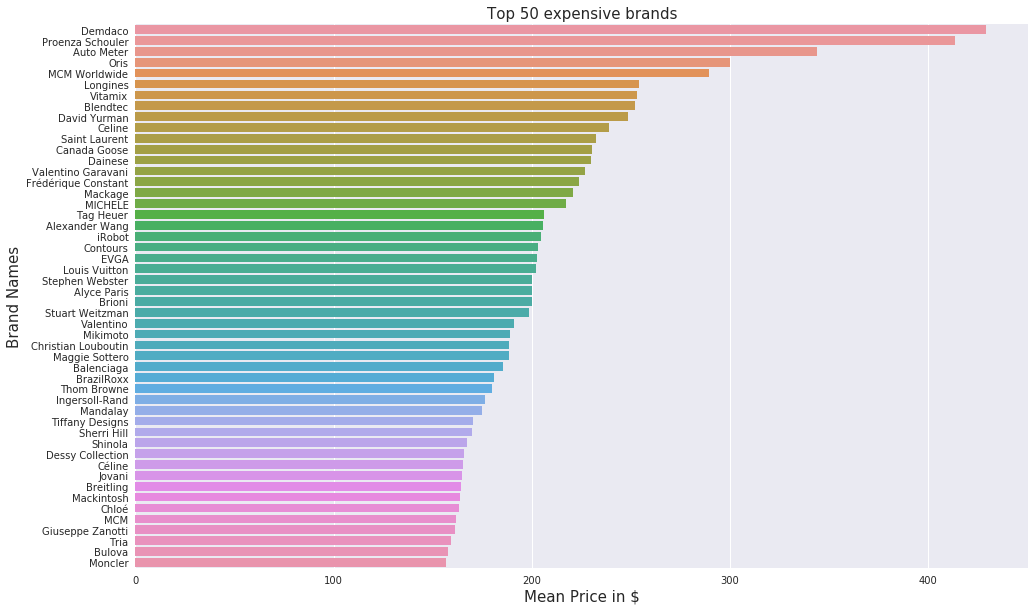

In [33]:
top_50_expensive_brand=train.groupby(['brand_name'])['price'].mean().sort_values(ascending=False)[:50]
sns.set(rc={'figure.figsize':(16,10)})
top_50_expensive_brand.reset_index()
ax=sns.barplot(y='brand_name',x='price',data=top_50_expensive_brand.reset_index())
ax.set_title('Top 50 expensive brands',fontsize=15)
ax.set_xlabel('Mean Price in $',fontsize=15)
ax.set_ylabel('Brand Names',fontsize=15)
plt.show()

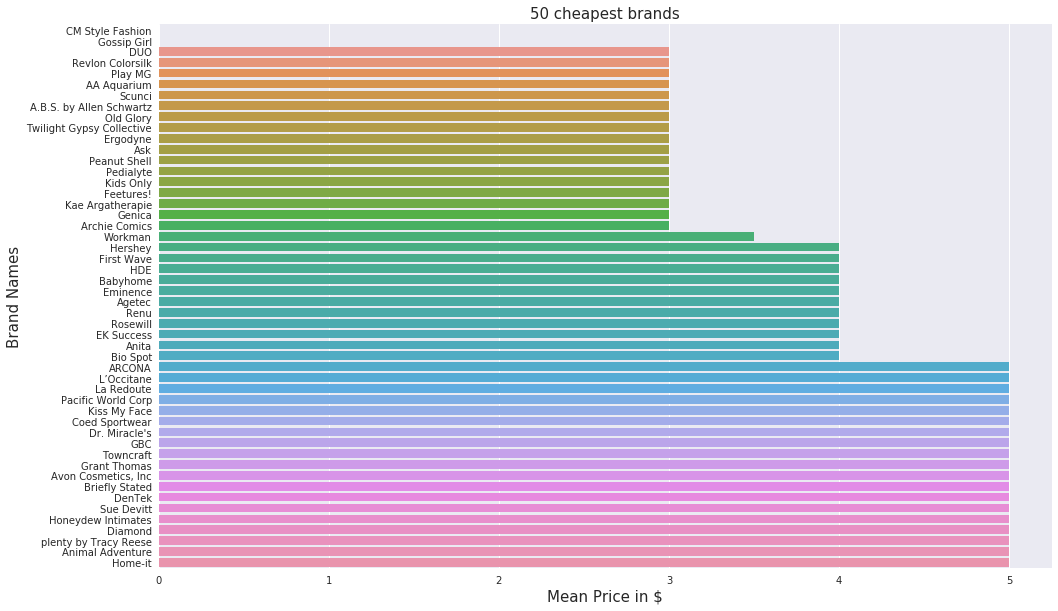

In [34]:
cheapest_50_brand=train.groupby(['brand_name'])['price'].mean().sort_values()[:50]
sns.set(rc={'figure.figsize':(16,10)})
ax=sns.barplot(y='brand_name',x='price',data=cheapest_50_brand.reset_index())
ax.set_title('50 cheapest brands',fontsize=15)
ax.set_xlabel('Mean Price in $',fontsize=15)
ax.set_ylabel('Brand Names',fontsize=15)
plt.show()


###### Input Feature: name

In [35]:
max_length_name=(train['name'].apply(lambda x:len(x.split()))).max()
print('The longest name field has:'+str(max_length_name)+' words')

The longest name field has:17 words


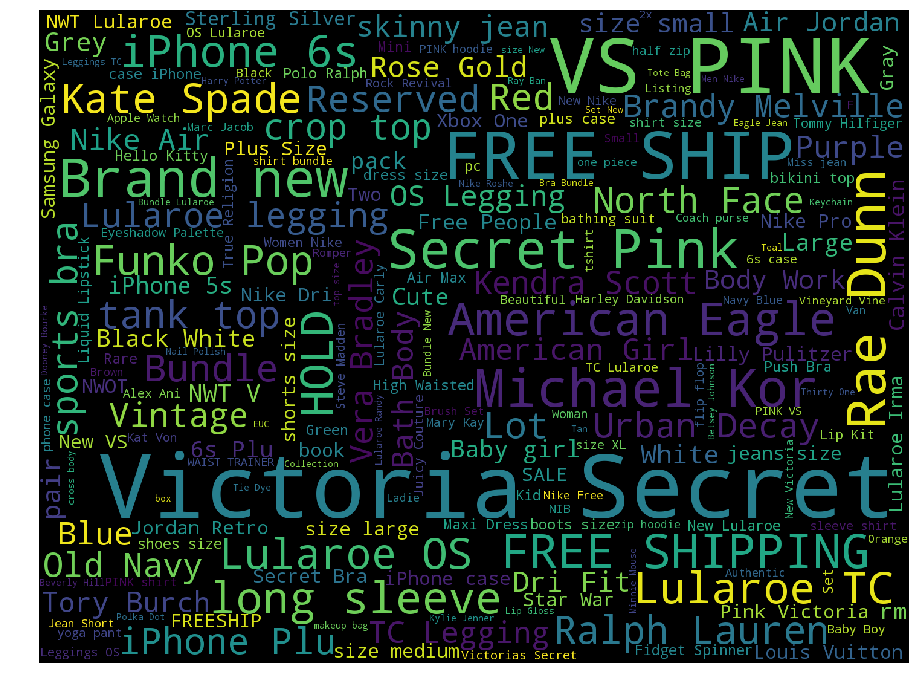

In [36]:
cloud = WordCloud(width=1440,height=1080).generate(" ".join(train['name'].astype(str)))
plt.figure(figsize=(18, 12))
plt.imshow(cloud)
plt.axis('off')
plt.show()

###### input feature: item_description

In [37]:
train['item_description'].fillna('No description yet',inplace=True)
max_length_description=(train['item_description'].apply(lambda x:len(x.split()))).max()
print('The longest description field has '+str(max_length_description)+' words')

The longest description field has 245 words


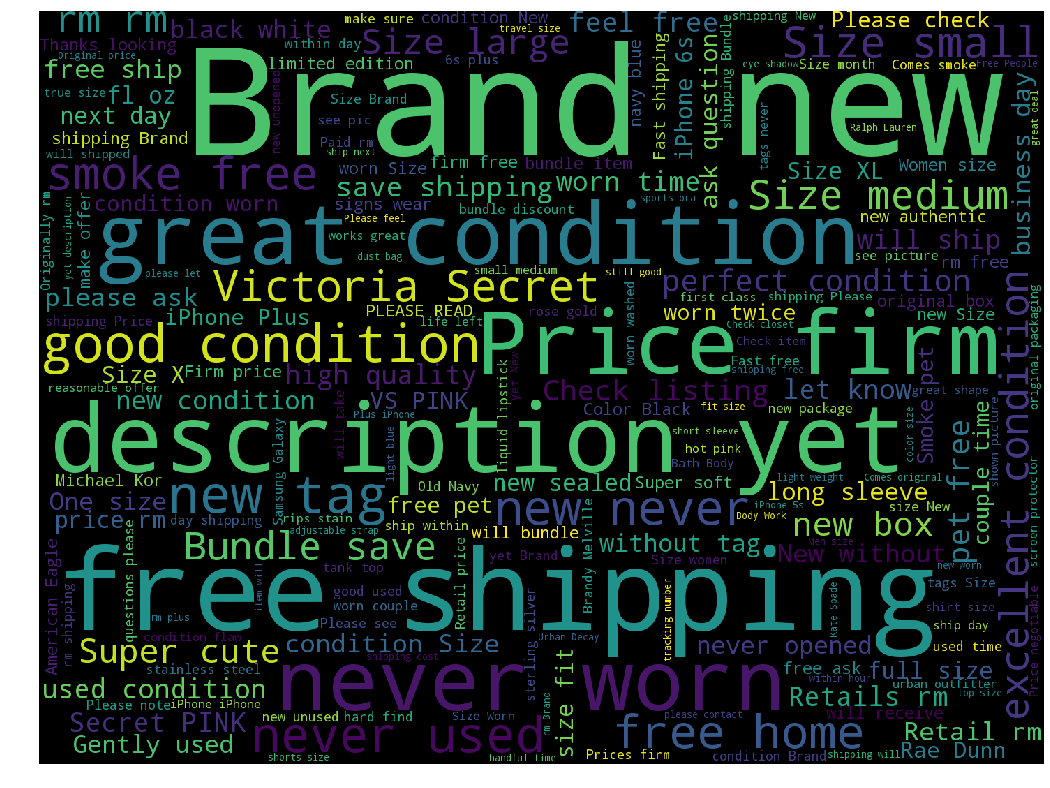

In [38]:
cloud = WordCloud(width=1440,height=1080).generate(" ".join(train['item_description'].astype(str)))
plt.figure(figsize=(18, 15))
plt.imshow(cloud)
plt.axis('off')
plt.show()

Notes:
The length of item descripton tokens after removed stop words and punctuations has negative correlation with price

### II. Data Preprocessing

In [39]:
# Function to clean up name column
def cleanName(text):
    try:
        textProc=text.lower()
        textProc=' '.join(map(str.strip,re.split('(\d+)',textProc)))
        regex=re.compile(u'[^A-Za-z0-9]+')
        textProc=regex.sub(' ',textProc)
        textProc=' '.join(textProc.split())
        
        return textProc
    except:
        return 'name error'

In [40]:
def getLastTwo(text):
    try:
        text=text.lower()
        regex=re.compile('['+re.escape(string.punctuation)+'0-9\\r\\t\\n]')
        text=regex.sub(' ',text)
        text=text.split()
        
        if len(text)==1:
            return text[0]
        
        text=text[-2]+' '+text[-1]
        return text
    except:
        return ' '

In [41]:
def split_cat(text):
    try:return text.split('/')
    except:return ('None','None','None')


In [42]:
df=pd.read_table('https://storage.googleapis.com/merca/train.tsv')
dfTest=pd.read_table('https://storage.googleapis.com/merca/test.tsv')
df.tail()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1482530,1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl..."
1482531,1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t
1482532,1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NaN,12.0,0,"Used once or twice, still in great shape."
1482533,1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,NaN,45.0,1,There is 2 of each one that you see! So 2 red ...
1482534,1482534,Brand new lux de ville wallet,1,Women/Women's Accessories/Wallets,NaN,22.0,0,"New with tag, red with sparkle. Firm price, no..."


In [43]:
print(df.shape)

(1482535, 8)


In [44]:
n_trains=df.shape[0]
y=np.log1p(df['price'].values)
submission=dfTest[['test_id']]

#### Data Cleaning---Training File

In [45]:
print('Set the parameters...')

NUM_BRANDS=3566  # brands appeared more than once
DESC_MAX_FEAT=500000
LGBM_NAME_MIN_DF=20
NAME_MIN_DF=2
DESC_MIN_DF=2

Set the parameters...


In [46]:
print('Filling missing data...')
df['brand_name']=df['brand_name'].fillna('unknown')
df['item_description']=df['item_description'].fillna('None')
df['name']=df['name'].fillna('None')
df['item_condition_id']=df['item_condition_id'].fillna(0)
df['shipping']=df['shipping'].fillna(0)
df['category_name']=df['category_name'].fillna('None/None/None')

Filling missing data...


In [47]:
print('Handling pop brands...')
pop_brands=df['brand_name'].value_counts().index[:NUM_BRANDS]
df.loc[~df['brand_name'].isin(pop_brands),'brand_name']='Other'

Handling pop brands...


In [48]:
print('Handling category fields...')
df['general_cat'],df['subcat_1'],df['subcat_2']=zip(*df['category_name'].apply(lambda x: split_cat(x)))
df['general_cat'].fillna(value='None',inplace=True)
df['subcat_1'].fillna(value='None',inplace=True)
df['subcat_2'].fillna(value='None',inplace=True)

df['general_cat']=df['general_cat'].astype('category')
df['subcat_1']=df['subcat_1'].astype('category')
df['subcat_2']=df['subcat_2'].astype('category')

df['item_condition_id']=df['item_condition_id'].astype('category')
df['shipping']=df['shipping'].astype('category')

Handling category fields...


In [49]:
print('Clean up the text fields...')
df['name']=df['name'].apply(lambda x: cleanName(x))
df['item_description']=df['item_description'].apply(lambda x:cleanName(x))
df['category_name']=df['category_name'].apply(lambda x:cleanName(x))
df['object']=df['name'].apply(lambda x:getLastTwo(x))

Clean up the text fields...


In [50]:
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2,object
0,0,mlb cincinnati reds t shirt size xl,3,men tops t shirts,unknown,10.0,1,no description yet,Men,Tops,T-shirts,size xl
1,1,razer blackwidow chroma keyboard,3,electronics computers tablets components parts,Razer,52.0,0,this keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,chroma keyboard
2,2,ava viv blouse,1,women tops blouses blouse,Target,10.0,1,adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,viv blouse
3,3,leather horse statues,1,home home d cor home d cor accents,unknown,35.0,1,new with tags leather horses retail for rm eac...,Home,Home Décor,Home Décor Accents,horse statues
4,4,24 k gold plated rose,1,women jewelry necklaces,unknown,44.0,0,complete with certificate of authenticity,Women,Jewelry,Necklaces,plated rose


#### Data cleaning --- Testing File

In [51]:
dfTest['brand_name']=dfTest['brand_name'].fillna('unknown')
dfTest['item_description']=dfTest['item_description'].fillna('None')
dfTest['Name']=dfTest['name'].fillna('None')
dfTest['item_condition_id']=dfTest['item_condition_id'].fillna(0)
dfTest['shipping']=df['shipping'].fillna(0)
dfTest['category_name']=dfTest['category_name'].fillna('None/None/None')

In [52]:
dfTest.loc[~dfTest['brand_name'].isin(pop_brands),'brand_name']='Other'
dfTest['general_cat'],dfTest['subcat_1'],dfTest['subcat_2']=zip(*dfTest['category_name'].apply(lambda x:split_cat(x)))
dfTest['general_cat'].fillna('None',inplace=True)
dfTest['subcat_1'].fillna('None',inplace=True)
dfTest['subcat_2'].fillna('None',inplace=True)

dfTest['general_cat']=dfTest['general_cat'].astype('category')
dfTest['subcat_1']=dfTest['subcat_1'].astype('category')
dfTest['subcat_2']=dfTest['subcat_2'].astype('category')

dfTest['item_condition_id']=dfTest['item_condition_id'].astype('category')
dfTest['shipping']=dfTest['shipping'].astype('category')

In [53]:
print('Clean up the text fields for testing file ...')
dfTest['name']=dfTest['name'].apply(lambda x:cleanName(x))
dfTest['item_description']=dfTest['item_description'].apply(lambda x:cleanName(x))
dfTest['category_name']=dfTest['category_name'].apply(lambda x:cleanName(x))
dfTest['object']=dfTest['name'].apply(lambda x:getLastTwo(x))


Clean up the text fields for testing file ...


In [54]:
dfTest.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,Name,general_cat,subcat_1,subcat_2,object
0,0,breast cancer i fight like a girl ring,1,women jewelry rings,unknown,1,size 7,"Breast cancer ""I fight like a girl"" ring",Women,Jewelry,Rings,girl ring
1,1,25 pcs new 7 5 x 12 kraft bubble mailers,1,other office supplies shipping supplies,unknown,0,25 pcs new 7 5 x 12 kraft bubble mailers lined...,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",Other,Office supplies,Shipping Supplies,bubble mailers
2,2,coach bag,1,vintage collectibles bags and purses handbag,Coach,1,brand new coach bag bought for rm at a coach o...,Coach bag,Vintage & Collectibles,Bags and Purses,Handbag,coach bag
3,3,floral kimono,2,women sweaters cardigan,unknown,1,floral kimono never worn lightweight and perfe...,Floral Kimono,Women,Sweaters,Cardigan,floral kimono
4,4,life after death,3,other books religion spirituality,unknown,0,rediscovering life after the loss of a loved o...,Life after Death,Other,Books,Religion & Spirituality,after death


In [55]:
from nltk.stem import WordNetLemmatizer
lemma  = WordNetLemmatizer()

class LemmaVectorizer(CountVectorizer):
    def build_analyzer(self):
        preprocess = self.build_preprocessor()
        stop_words = self.get_stop_words()
        tokenize = self.build_tokenizer()
        l_adder = self.lemma_adder()
        return lambda doc: self._word_ngrams(l_adder(tokenize(preprocess(self.decode(doc)))), stop_words)

    def lemma_adder(self):
        def lemmatizer(tokens):
            return list(set([lemma.lemmatize(w) for w in tokens] + tokens))
            
        return lemmatizer

    def build_tokenizer(self):
        """Return a function that splits a string into a sequence of tokens"""
        def tokenizer(doc):
            token_pattern = re.compile(self.token_pattern)
            return token_pattern.findall(doc)
            
        return tokenizer 

In [56]:
print('Name Feature 1')

count=LemmaVectorizer(min_df=LGBM_NAME_MIN_DF,
                     decode_error='replace',
                     ngram_range=(1,1),
                     token_pattern=r'(?u)\b\w+\b',
                     strip_accents='unicode')

X_name_1=count.fit_transform(df['name'])
X_name_1_Test=count.transform(dfTest['name'])

Name Feature 1


In [57]:
print('Category Features ... ')
count=CountVectorizer(ngram_range=(1,1),
                   decode_error='replace',
                     token_pattern=r'(?u)\b\w+\b',
                    strip_accents='unicode')

X_category=count.fit_transform(df['category_name'])
X_category_Test=count.transform(dfTest['category_name'])

print('Categories Features Transformed!')

Category Features ... 
Categories Features Transformed!


In [58]:
del count

In [59]:
print('Object Feature')
count=CountVectorizer(min_df=LGBM_NAME_MIN_DF,decode_error='replace')
X_object=count.fit_transform(df['object'])
X_object_Test=count.transform(dfTest['object'])
del count

Object Feature


In [60]:
print('Brand Features')
count=LemmaVectorizer(ngram_range=(1,1),
                     decode_error='replace',
                     token_pattern=r'(?u)\b\w+\b',
                     strip_accents='unicode')
X_brand=count.fit_transform(df['brand_name'])
X_brand_Test=count.transform(dfTest['brand_name'])
del count
gc.collect()

Brand Features


0

In [61]:
print('Item Cond & Shipping Features')
ohe=OneHotEncoder(dtype=np.float32,handle_unknown='ignore')
X_dummies=ohe.fit_transform(np.array([df['item_condition_id'].tolist(),df['shipping'].tolist()]).T)
X_dummies_Test=ohe.transform(np.array([dfTest['item_condition_id'].tolist(),dfTest['shipping'].tolist()]).T)
del ohe
gc.collect()

Item Cond & Shipping Features


0

In [62]:
print('Description Features')
count_descp=CountVectorizer(max_features=DESC_MAX_FEAT,
                           decode_error='ignore',
                           min_df=LGBM_NAME_MIN_DF,
                           ngram_range=(1,1),
                           token_pattern=r'(?u)\b\w+\b',
                           strip_accents='unicode')

X_descp=count_descp.fit_transform(df['item_description'])

X_descp_add=count_descp.transform(df['name'])
X_descp=X_descp+X_descp_add

X_descp_Test=count_descp.transform(dfTest['item_description']) 
X_descp_add_Test=count_descp.transform(dfTest['name']) 
X_descp_Test=X_descp_Test+X_descp_add_Test

del count_descp
del X_descp_add
del X_descp_add_Test
gc.collect()

Description Features


0

In [63]:
#del df
#gc.collect()

In [64]:
print('X_name_1 {}'.format(X_name_1.shape))
print('X_category {}'.format(X_category.shape))
print('X_object {}'.format(X_object.shape))
print('X_brand {}'.format(X_brand.shape))
print('X_dummies {}'.format(X_dummies.shape))
print('X_descp {}'.format(X_descp.shape))

X_name_1 (1482535, 12390)
X_category (1482535, 1020)
X_object (1482535, 7528)
X_brand (1482535, 4062)
X_dummies (1482535, 7)
X_descp (1482535, 22149)


In [65]:
print('X_name_1_Test {}'.format(X_name_1_Test.shape))
print('X_category_Test {}'.format(X_category_Test.shape))
print('X_object_Test {}'.format(X_object_Test.shape))
print('X_brand_Test {}'.format(X_brand_Test.shape))
print('X_dummies_Test {}'.format(X_dummies_Test.shape))
print('X_descp_Test {}'.format(X_descp_Test.shape))

X_name_1_Test (693359, 12390)
X_category_Test (693359, 1020)
X_object_Test (693359, 7528)
X_brand_Test (693359, 4062)
X_dummies_Test (693359, 7)
X_descp_Test (693359, 22149)


In [66]:
print('Concatenate X_1')
X_1=hstack((X_dummies,
           X_descp,
           X_brand,
           X_category,
           X_name_1,
           X_object)).tocsr()

X_1_Test=hstack((X_dummies_Test,
                X_descp_Test,
                X_brand_Test,
                X_category_Test,
                X_name_1_Test,
                X_object_Test)).tocsr()

Concatenate X_1


In [67]:
#del X_dummies,X_descp,X_brand,X_category,X_name_1,X_object,\
#    X_dummies_Test,X_descp_Test,X_brand_Test,X_category_Test,X_name_1_Test,X_object_Test

#gc.collect()

In [68]:
print('X_1 {}'.format(X_1.shape))
print('X_1_Test {}'.format(X_1_Test.shape))

X_1 (1482535, 47156)
X_1_Test (693359, 47156)


### III. Loss Function

In [69]:
def rmsle(y,y_pred):
    assert len(y)==len(y_pred)
    return np.sqrt(np.square(np.log(y_pred+1)-np.log(y+1)).mean())

In [70]:
def rmse(y,h):
    return np.sqrt(np.square(h-y).mean())

In [71]:
def rmsle_lgb(preds,dtrain):
    y=list(dtrain.get_label())
    
    y_pred=np.expm1(preds)
    y_tar=np.expm1(y)
    
    score=rmsle(y_tar,y_pred)
    return 'rmsle',score,False

### IV. Model Training

In [72]:
np.random.seed(8)

In [73]:
filterTrain=np.where((np.expm1(y)>1))
y=y[filterTrain[0]]
X_1=X_1[filterTrain[0]]

In [74]:
train_X,valid_X,train_y,valid_y=train_test_split(X_1,y,test_size=0.15,random_state=888)

#### Benchmark Model: Ridge (Solver='auto')

In [75]:
print('Starting training benchmark model ...')
model=Ridge(solver='auto',random_state=111)
model.fit(train_X,train_y)

valid_pred_=model.predict(valid_X)
valid_pred=np.expm1(valid_pred_)

valid_rmsle=rmsle(np.expm1(valid_y),valid_pred)
print('Benchmark RMSLE is:'+str(valid_rmsle))


Starting training benchmark model ...
Benchmark RMSLE is:0.473336171826


#### Ridge Model (solver='sag')

In [76]:
print('Training Ridge sag Model ...')
model=Ridge(alpha=0.29,max_iter=800,solver='sag',tol=0.001,fit_intercept=True,normalize=False,random_state=999)
model.fit(train_X,train_y)
ridge_valid_pred=model.predict(valid_X)

print('Model prediction finished ...')

Training Ridge sag Model ...
Model prediction finished ...


In [77]:
ridge_valid=np.exp(ridge_valid_pred)-1
valid_y_=np.exp(valid_y)-1
print('Validation RMSLE:' +str(rmsle(valid_y_,ridge_valid)))

Validation RMSLE:0.473429998962


#### LGBM Model

In [78]:
print('Training LGBM Model')
d_train=lgb.Dataset(train_X,label=train_y)
d_valid=lgb.Dataset(valid_X,label=valid_y)

params={
    'max_bin':255,
    'min_data_in_leaf':1,
    'learning_rate':0.15,
    'application':'regression',
    'max_depth':20,
     'num_leaves':90,
    'verbosity':-1,
     'metric':'RMSE',
    'data_random_seed':1,
    'bagging_freq':0,
    'bagging_fraction':0.5,
     'feature_fraction':1,
    'lambda_l1':2,
     'lambda_l2':0,
    'nthread':4,
    'bin_construct_sample_cnt':50000
 }

model=lgb.train(params,train_set=d_train,valid_sets=d_valid,num_boost_round=3200,verbose_eval=500)


Training LGBM Model
[500]	valid_0's rmse: 0.446611
[1000]	valid_0's rmse: 0.430859
[1500]	valid_0's rmse: 0.423198
[2000]	valid_0's rmse: 0.418906
[2500]	valid_0's rmse: 0.416137
[3000]	valid_0's rmse: 0.414358


In [79]:
#Print out validation RMSLE
valid_pred=model.predict(valid_X)
lgb_v_rmsle=rmsle(np.expm1(valid_y),np.expm1(valid_pred))
print('LightGBM RMSEL is:'+str(lgb_v_rmsle))

LightGBM RMSEL is:0.413797103476


In [80]:
y_pred_4=model.predict(X_1_Test)

In [81]:
print('Generate submission file ...')
submission.loc[:, 'price'] = np.expm1(y_pred_4)
submission.loc[submission['price'] < 0.0, 'price'] = 0.0
submission.to_csv("submission_ridge.csv", index=False)
print('Output file generated!')

Generate submission file ...


/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Output file generated!


### V. Parameters Tuning

In [82]:
import sys
from pprint import pprint
from hyperopt import hp,tpe,STATUS_OK,Trials
from hyperopt.fmin import fmin

In [83]:
# hyperopt parameters to tune

space={
    'learning_rate':hp.uniform('learning_rate',0.05,0.25),
    'max_bin':hp.choice('max_bin',[255,510,765]),
    'min_data_in_leaf':hp.choice('min_data_in_leaf',[1,3]),
    'max_depth':hp.choice('max_depth',[-1,5,10,15,20,25]),
    'num_leaves':hp.choice('num_leaves',[60,90,120]),
    'bagging_frequency':hp.choice('bagging_freq',[0,5,10]),
    'bagging_fractioon':hp.uniform('bagging_fraction',0.25,0.6),
    'lambda_l1':hp.uniform('lambda_l1',0,2),
    'bin_construct_sample_cnt':hp.choice('bin_construct_sampe_cnt',[20000,50000,70000]),
    'application':hp.choice('application',['regression']),
    'verbosity':hp.choice('verbosity',[-1]),
    'metric':hp.choice('metric',['RMSE']),
    'data_random_seed':hp.choice('data_random_seed',[1]),
    'lambda_l2':hp.choice('lambda_l2',[0]),
    'nthread':hp.choice('nthread',[4])
}

In [84]:
def objective(space):
    print()
    print("Starting parametes tuning...")
    pprint(space)
    sys.stdout.flush()
    
    lgb_model=lgb.train(params=space,
                        train_set=d_train,
                        valid_sets=d_valid,
                        num_boost_round=3200,
                        early_stopping_rounds=50,
                        verbose_eval=500)
    lgb_pred=lgb_model.predict(valid_X)
    loss=rmsle(np.expm1(valid_y),np.expm1(lgb_pred))
    print('Loss:{}'.format(loss))
    sys.stdout.flush()
    return {'loss':loss,'status':STATUS_OK}
    

In [85]:
trials=Trials()
best=fmin(fn=objective,
         space=space,
         algo=tpe.suggest,
         max_evals=50,
         trials=trials)

print ('The best parameters are:', best)




Starting parametes tuning...
{'application': 'regression',
 'bagging_fractioon': 0.4827931099385663,
 'bagging_frequency': 5,
 'bin_construct_sample_cnt': 20000,
 'data_random_seed': 1,
 'lambda_l1': 0.4481746914922722,
 'lambda_l2': 0,
 'learning_rate': 0.18593609347536022,
 'max_bin': 765,
 'max_depth': 20,
 'metric': 'RMSE',
 'min_data_in_leaf': 1,
 'nthread': 4,
 'num_leaves': 120,
 'verbosity': -1}
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 0.439702
[1000]	valid_0's rmse: 0.426442
[1500]	valid_0's rmse: 0.420709
[2000]	valid_0's rmse: 0.417536
[2500]	valid_0's rmse: 0.415553
[3000]	valid_0's rmse: 0.414321
Did not meet early stopping. Best iteration is:
[3200]	valid_0's rmse: 0.413926
Loss:0.4139264660006773

Starting parametes tuning...
{'application': 'regression',
 'bagging_fractioon': 0.3129788776146572,
 'bagging_frequency': 5,
 'bin_construct_sample_cnt': 20000,
 'data_random_seed': 1,
 'lambda_l1': 1.6854108033128297,
 'lambda_l2': 

[2000]	valid_0's rmse: 0.425421
[2500]	valid_0's rmse: 0.421655
[3000]	valid_0's rmse: 0.418767
Did not meet early stopping. Best iteration is:
[3200]	valid_0's rmse: 0.417793
Loss:0.4177929652038165

Starting parametes tuning...
{'application': 'regression',
 'bagging_fractioon': 0.4760016515925182,
 'bagging_frequency': 10,
 'bin_construct_sample_cnt': 50000,
 'data_random_seed': 1,
 'lambda_l1': 0.436631266587872,
 'lambda_l2': 0,
 'learning_rate': 0.11770996703019623,
 'max_bin': 510,
 'max_depth': 5,
 'metric': 'RMSE',
 'min_data_in_leaf': 1,
 'nthread': 4,
 'num_leaves': 90,
 'verbosity': -1}
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 0.507025
[1000]	valid_0's rmse: 0.484817
[1500]	valid_0's rmse: 0.472305
[2000]	valid_0's rmse: 0.464179
[2500]	valid_0's rmse: 0.458297
[3000]	valid_0's rmse: 0.453601
Did not meet early stopping. Best iteration is:
[3200]	valid_0's rmse: 0.452083
Loss:0.4520831762413839

Starting parametes tuning...
{'appli

Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 0.441488
[1000]	valid_0's rmse: 0.427438
[1500]	valid_0's rmse: 0.421292
[2000]	valid_0's rmse: 0.417954
[2500]	valid_0's rmse: 0.415616
[3000]	valid_0's rmse: 0.413918
Did not meet early stopping. Best iteration is:
[3200]	valid_0's rmse: 0.413378
Loss:0.41337801376093786

Starting parametes tuning...
{'application': 'regression',
 'bagging_fractioon': 0.3723882066206345,
 'bagging_frequency': 5,
 'bin_construct_sample_cnt': 70000,
 'data_random_seed': 1,
 'lambda_l1': 1.4604336458602656,
 'lambda_l2': 0,
 'learning_rate': 0.16880197330054725,
 'max_bin': 765,
 'max_depth': 25,
 'metric': 'RMSE',
 'min_data_in_leaf': 3,
 'nthread': 4,
 'num_leaves': 120,
 'verbosity': -1}
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 0.437623
[1000]	valid_0's rmse: 0.423875
[1500]	valid_0's rmse: 0.418115
[2000]	valid_0's rmse: 0.415046
[2500]	valid_0's rmse: 0.413005
[3000]	valid_

Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 0.432922
[1000]	valid_0's rmse: 0.421729
[1500]	valid_0's rmse: 0.417493
[2000]	valid_0's rmse: 0.415446
[2500]	valid_0's rmse: 0.413992
[3000]	valid_0's rmse: 0.413137
Did not meet early stopping. Best iteration is:
[3199]	valid_0's rmse: 0.412781
Loss:0.4127811933174377

Starting parametes tuning...
{'application': 'regression',
 'bagging_fractioon': 0.43140051169889254,
 'bagging_frequency': 5,
 'bin_construct_sample_cnt': 70000,
 'data_random_seed': 1,
 'lambda_l1': 1.3259885931946755,
 'lambda_l2': 0,
 'learning_rate': 0.24871798774588544,
 'max_bin': 765,
 'max_depth': 25,
 'metric': 'RMSE',
 'min_data_in_leaf': 3,
 'nthread': 4,
 'num_leaves': 60,
 'verbosity': -1}
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 0.440018
[1000]	valid_0's rmse: 0.428116
[1500]	valid_0's rmse: 0.423138
[2000]	valid_0's rmse: 0.420039
[2500]	valid_0's rmse: 0.417931
[3000]	valid_0

Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 0.459027
[1000]	valid_0's rmse: 0.441026
[1500]	valid_0's rmse: 0.432243
[2000]	valid_0's rmse: 0.427094
[2500]	valid_0's rmse: 0.423272
[3000]	valid_0's rmse: 0.420516
Did not meet early stopping. Best iteration is:
[3200]	valid_0's rmse: 0.419536
Loss:0.4195363722843838

Starting parametes tuning...
{'application': 'regression',
 'bagging_fractioon': 0.3908967803392764,
 'bagging_frequency': 0,
 'bin_construct_sample_cnt': 20000,
 'data_random_seed': 1,
 'lambda_l1': 1.6404359806404012,
 'lambda_l2': 0,
 'learning_rate': 0.15491652677176698,
 'max_bin': 510,
 'max_depth': -1,
 'metric': 'RMSE',
 'min_data_in_leaf': 3,
 'nthread': 4,
 'num_leaves': 90,
 'verbosity': -1}
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 0.439699
[1000]	valid_0's rmse: 0.427792
[1500]	valid_0's rmse: 0.422225
[2000]	valid_0's rmse: 0.418812
[2500]	valid_0's rmse: 0.416476
[3000]	valid_0'

### VI. Conclusion

##### Benchmark Model: Ridge Auto model: Validation RMSLE:0.473336171826

##### Ridge Sag model: Validation RMSLE:0.473429998962

##### LightGBM Model: Validation RMSLE is:0.413797103476

##### Tuned LightGBM Model: Validation RMSLE: 0.411179 
<p>Tuned parameters as below:
<p>leaning_rate: 0.18
<p>nthread:4
<p>lambda_l2:0
<p>lambda_l1:1.1
<p>application:'regression'
<p>max_bin:765
<p>lambda_l1:1.11
<p>bin_construct_same_cnt:70000
<p>num_leaves:120
<p>min_data_in_leaf:3
<p>metric:'RMSE'
<p>bagging_freq:5
<p>max_depth:25
<p>bagging_fraction:0.43
            